# Libraries

In [640]:
import numpy as np #array operations
import matplotlib.pyplot as plt #ploting operations
from matplotlib.image import imread #display images

# from torchvision.datasets import ImageFolder
# import torchvision.transforms as transforms

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers #model building

#from sklearn.model_selection import train_test_split #Split data
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


#Transfer learning 
from tensorflow.keras.applications import EfficientNetB0


In [646]:
# CONSTANTS
DATASET_DIR = 'PokemonData/' #Folder in current working directory 
IMG_SIZE = 64 #(Height, Width) Can rerun with bigger dims
BATCH_SIZE = 32 #Want Data Split to have same batch size
SEED = 1337 #Want Data Split to have same seed

# Image Loading
Dataset from kaggle contains 6820 (150 unique) pokemon images of varying size from google
This Dataset doesn't contain NidoranM or NidoranF from the original 151 pokemon and adds alolan Sandslash for some reason. I decided not to change that because the two are extremely similar.

In [645]:
#Assigns the (dataset) images class numbers in alphabetical order  
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


In [647]:
class_names = train_data.class_names #The list contains all class names
print(class_names[:10]) #Display first 10
NUM_CLASSES = len(class_names) #150

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

# Visualization of Images and Class

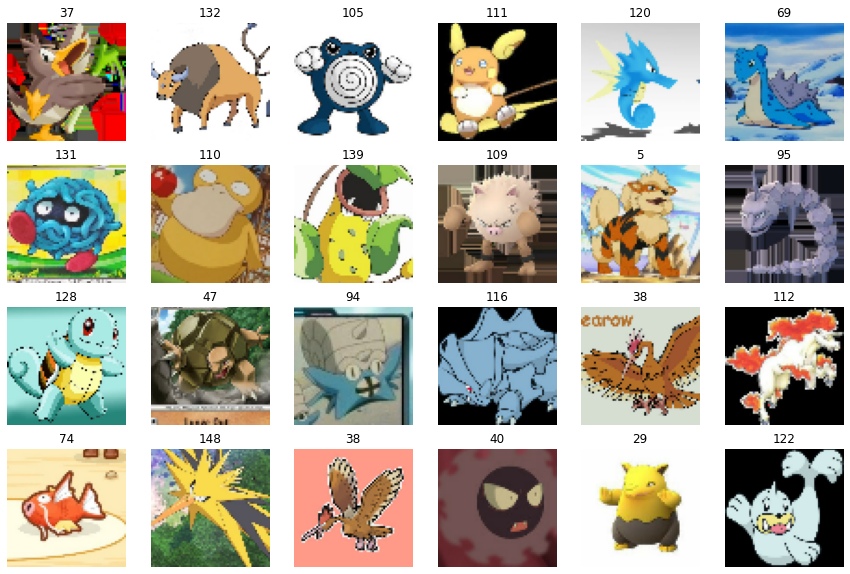

In [628]:
#Print 25 samples (following lab4b and https://www.tensorflow.org/tutorials/images/classification)
plt.figure(figsize=(15, 10))
for images, labels in train_data.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data Augmentation
The dataset already contains a lot of Data and I can easily fetch more images from other compiled sets or google, but I'll try to use simple Flip, Rotation and Zoom operations to augment data as seen in lab4b and https://www.tensorflow.org/tutorials/images/classification

In [629]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(),
        layers.experimental.preprocessing.RandomRotation(0.15),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomContrast(factor=0.1),
    ]
)

# Data Preprocessing
Standardizing RBG values to [0,1] by using a Rescaling layer
Data_augmentation preprocessor will execute synchronously with the rest of the model execution to benefit from GPU acceleration

In [465]:
#Configure the dataset for performance
train_data = train_data.prefetch(buffer_size=32)
val_data = val_data.prefetch(buffer_size=32)

In [83]:
# Basic model from Tensorflow tutorial with some changes
model = keras.Sequential([
    data_augmentation, #Preprocess
    layers.Rescaling(1./255), #Preprocess
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), #Combats overfitting
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes) #maybe add softmax activation
])

# Train (compile and fit) model

In [84]:
epochs = 50 #tried several different epoachs and found anything below 100 wasn't very good

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_data, epochs=epochs, callbacks=callbacks, validation_data=val_data,
)

Epoch 1/100
171/171 [==============================] - 17s 95ms/step - loss: 4.8751 - accuracy: 0.0163 - val_loss: 4.5369 - val_accuracy: 0.0352
Epoch 2/100
171/171 [==============================] - 15s 88ms/step - loss: 4.2237 - accuracy: 0.0583 - val_loss: 3.7935 - val_accuracy: 0.1085
Epoch 3/100
171/171 [==============================] - 15s 87ms/step - loss: 3.6036 - accuracy: 0.1299 - val_loss: 3.2874 - val_accuracy: 0.1862
Epoch 4/100
171/171 [==============================] - 19s 107ms/step - loss: 3.2326 - accuracy: 0.1871 - val_loss: 3.1146 - val_accuracy: 0.2097
Epoch 5/100
171/171 [==============================] - 21s 120ms/step - loss: 2.9348 - accuracy: 0.2498 - val_loss: 2.7493 - val_accuracy: 0.3094
Epoch 6/100
171/171 [==============================] - 26s 148ms/step - loss: 2.7153 - accuracy: 0.2889 - val_loss: 2.6691 - val_accuracy: 0.3372
Epoch 7/100
171/171 [==============================] - 23s 134ms/step - loss: 2.5833 - accuracy: 0.3213 - val_loss: 2.5441 - va

Epoch 57/100
171/171 [==============================] - 20s 118ms/step - loss: 0.8366 - accuracy: 0.7443 - val_loss: 2.0856 - val_accuracy: 0.5814
Epoch 58/100
171/171 [==============================] - 22s 130ms/step - loss: 0.8371 - accuracy: 0.7423 - val_loss: 1.9254 - val_accuracy: 0.5975
Epoch 59/100
171/171 [==============================] - 23s 131ms/step - loss: 0.8279 - accuracy: 0.7449 - val_loss: 2.1227 - val_accuracy: 0.5850
Epoch 60/100
171/171 [==============================] - 22s 124ms/step - loss: 0.8504 - accuracy: 0.7322 - val_loss: 2.0563 - val_accuracy: 0.5777
Epoch 61/100
171/171 [==============================] - 21s 122ms/step - loss: 0.8021 - accuracy: 0.7484 - val_loss: 2.0151 - val_accuracy: 0.5872
Epoch 62/100
171/171 [==============================] - 21s 120ms/step - loss: 0.8013 - accuracy: 0.7496 - val_loss: 1.9337 - val_accuracy: 0.5968
Epoch 63/100
171/171 [==============================] - 23s 130ms/step - loss: 0.7829 - accuracy: 0.7608 - val_loss: 2

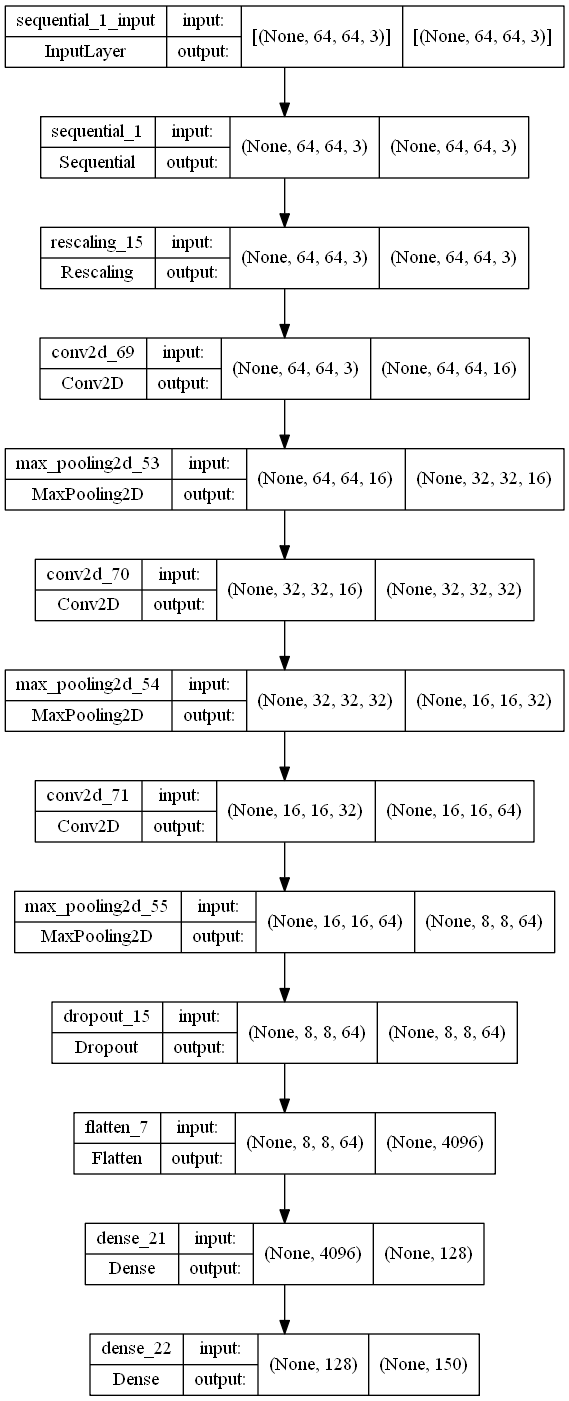

In [85]:
keras.utils.plot_model(model, show_shapes=True)

# Visualize Training Results

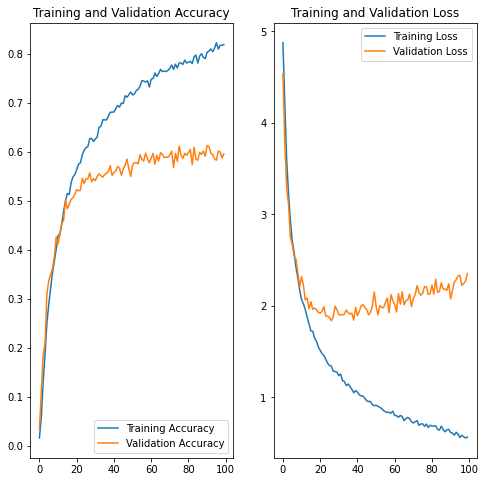

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to Abra with a 92.24 percent confidence.


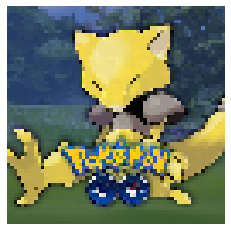

In [98]:
ABRA = 'abra.jpg' #Unseen Abra I downloaded from google

img = tf.keras.utils.load_img(
    ABRA, target_size=(IMG_SIZE, IMG_SIZE)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.axis("off")

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#After 100 epoachs the model was able to correctly identify a Abra

Created a Testing DataSet to test measures of accuracy because I didn't want to split my current Training Set. Testing Set contains at least 5 images per class sourced from google using one month filter to get different images from Training/Validation Data

In [648]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='TestData/', 
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 795 files belonging to 150 classes.


In [435]:
#y_pred = model.predict(test_data)
model.evaluate(test_data)

25/25 [==============================] - 2s 61ms/step - loss: 7.7124 - accuracy: 0.2377


[7.712438583374023, 0.23773585259914398]

# Visualization of Accuracies

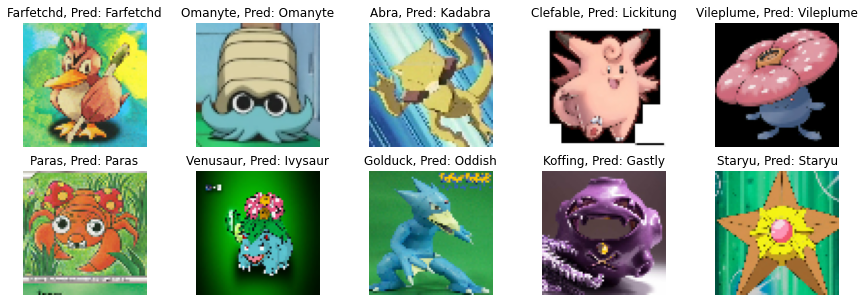

In [436]:
#Validation Accuracy for the basic CNN was 60 percent
plt.figure(figsize=(15, 5))
for images, labels in val_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        
        plt.title(str(class_names[labels[i]]) + ', Pred: ' + str(class_names[np.argmax(score)]))
        plt.axis("off")

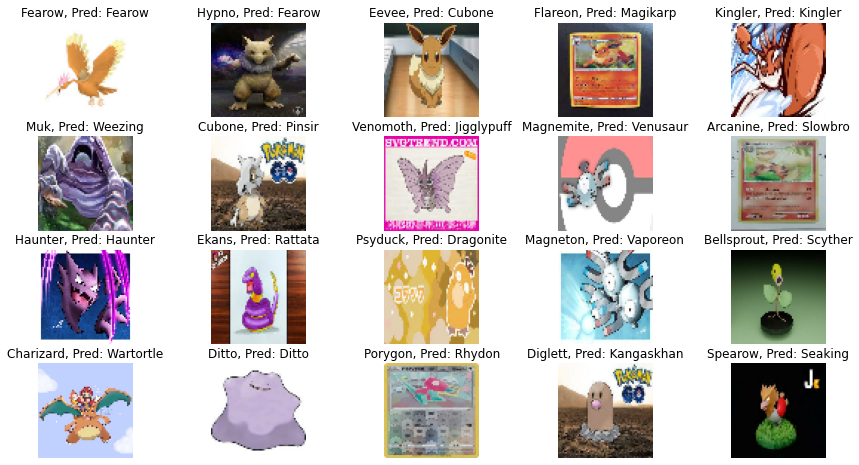

In [443]:
#Test Accuracy for the basic CNN was 24 percent
plt.figure(figsize=(15, 8))
y_test = np.array([])
y_pred = []
for images, labels in test_data.take(1):
    for i in range(BATCH_SIZE): 
        
        predictions = model.predict(images)
        score = tf.nn.softmax(predictions[i])
        
        if i < 20: #only want to print first 20 but want to get true labels and prediction labels for batch
            ax = plt.subplot(4, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            plt.title(str(class_names[labels[i]]) + ', Pred: ' + str(class_names[np.argmax(score)]))
            plt.axis("off")
       
        true = class_names[labels[i]] #actual labels casted to their class name
        y_test = np.append(y_test, true)
        pred = class_names[np.argmax(score)] # predicted labels casted into their class names
        y_pred = np.append(y_pred, pred)

In [471]:
#Method to print sklearn metrics for classificatino data
def print_metrics(targets, predictions):
    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro', zero_division=1)
    recall = recall_score(targets, predictions, average='macro', zero_division=1)
    precision = precision_score(targets, predictions, average='macro', zero_division=1)
    print('Accuracy: %.3f \nF-score: %.3f \nRecall: %.3f \nPrecision: %.3f' % (accuracy, f1, recall, precision))

In [472]:
#Classification (we have 150 classes but only using 32 samples here)
#print(classification_report(y_test, y_pred, zero_division=1))

print_metrics(y_test, y_pred)

Accuracy: 25.000 
F-score: 0.146 
Recall: 0.542 
Precision: 0.552


# EfficientNet Model
Model from lab10

In [649]:
IMG_SIZE = 224 #size determined by EfficientNet model choice
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 64

In [650]:
#Reloading Dataset in higher resolution 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

train_data = train_data.map(lambda image, label: (tf.image.resize(image, SIZE), label))
val_data = val_data.map(lambda image, label: (tf.image.resize(image, SIZE), label))

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


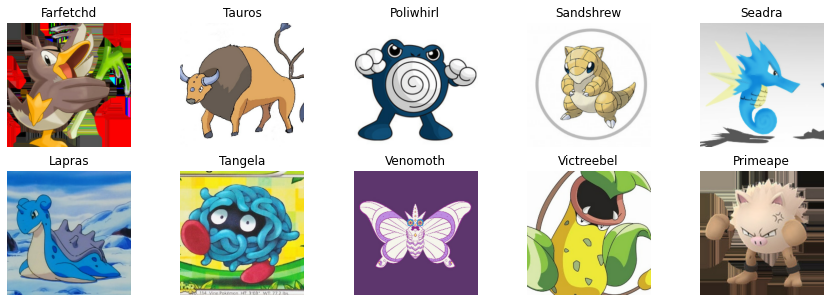

In [633]:
#Visualize images with higher resolution
plt.figure(figsize=(15, 5))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(class_names[labels[i]]))
        plt.axis("off")

# Data augmentation

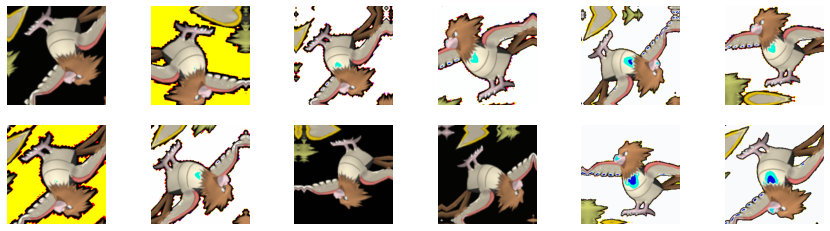

In [639]:
plt.figure(figsize=(15,4))
for images, labels in train_data.take(1):
    for i in range(12):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(2, 6, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# EfficientNet Model

In [660]:
def EfficientNet(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="SparseCategoricalCrossentropy", metrics=["accuracy"]
    )
    return model


In [661]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [667]:
epochs = 15 # @param {type: "slider", min:8, max:80}

with strategy.scope():
    model = EfficientNet(num_classes=NUM_CLASSES)
    
hist = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)

Epoch 1/15
86/86 - 274s - loss: 3.3620 - accuracy: 0.4080 - val_loss: 1.7921 - val_accuracy: 0.5601 - 274s/epoch - 3s/step
Epoch 2/15
86/86 - 275s - loss: 1.4827 - accuracy: 0.6760 - val_loss: 1.5045 - val_accuracy: 0.6378 - 275s/epoch - 3s/step
Epoch 3/15
86/86 - 254s - loss: 1.0946 - accuracy: 0.7434 - val_loss: 1.3813 - val_accuracy: 0.6987 - 254s/epoch - 3s/step
Epoch 4/15
86/86 - 257s - loss: 0.8494 - accuracy: 0.7927 - val_loss: 1.5965 - val_accuracy: 0.6774 - 257s/epoch - 3s/step
Epoch 5/15
86/86 - 256s - loss: 0.7698 - accuracy: 0.8032 - val_loss: 1.5727 - val_accuracy: 0.6928 - 256s/epoch - 3s/step
Epoch 6/15
86/86 - 297s - loss: 0.7197 - accuracy: 0.8149 - val_loss: 1.4767 - val_accuracy: 0.7097 - 297s/epoch - 3s/step
Epoch 7/15
86/86 - 314s - loss: 0.6330 - accuracy: 0.8332 - val_loss: 1.6664 - val_accuracy: 0.7016 - 314s/epoch - 4s/step
Epoch 8/15
86/86 - 308s - loss: 0.6134 - accuracy: 0.8347 - val_loss: 1.6859 - val_accuracy: 0.7082 - 308s/epoch - 4s/step
Epoch 9/15
86/86

In [669]:
# Method to print test-val accuracy and test-val loss
def plot_acc_loss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.show()

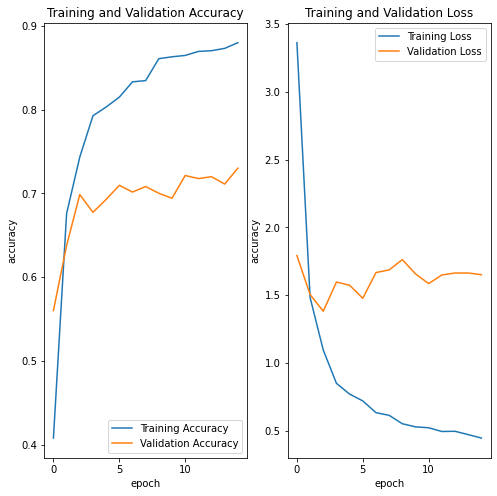

In [670]:
plot_acc_loss(hist)

In [ ]:
def unfreeze_model(model):
    # unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="SparseCategoricalCrossentropy", metrics=["accuracy"]
    )

epochs = 10  # @param {type: "slider", min:8, max:50}
unfreeze_model(model)
hist = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)

Epoch 1/10
86/86 - 305s - loss: 0.3152 - accuracy: 0.9122 - val_loss: 1.3403 - val_accuracy: 0.7676 - 305s/epoch - 4s/step
Epoch 2/10
86/86 - 397s - loss: 0.2203 - accuracy: 0.9360 - val_loss: 1.3046 - val_accuracy: 0.7683 - 397s/epoch - 5s/step
Epoch 3/10
86/86 - 364s - loss: 0.1736 - accuracy: 0.9465 - val_loss: 1.2224 - val_accuracy: 0.7786 - 364s/epoch - 4s/step
Epoch 4/10
86/86 - 312s - loss: 0.1572 - accuracy: 0.9534 - val_loss: 1.2024 - val_accuracy: 0.7874 - 312s/epoch - 4s/step
Epoch 5/10


In [ ]:
plot_acc_loss(hist)